# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# Enable Float64 for more stable matrix inversions.
from jax import config
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
from typing import Callable, Dict, List, Optional, Tuple
from jax import Array, config, jit, value_and_grad
from jax.tree_util import Partial, tree_map
from tinygp import kernels, GaussianProcess
import tinygp
import equinox as eqx
import jax.numpy as jnp

import jax.random as jr
from jaxtyping import ArrayLike, PyTree

import optax as ox

In [10]:
def mean_function(params, x):
    return params["mean_loc"] * jnp.squeeze(x)

In [23]:
mean_func=mean_function

In [27]:
callable(mean_func)

True

In [11]:
params = {
    "mean_loc": 5.0,
    "log_amp": 4.22973472,
    "log_diag": 0.95159482,
    "log_scale": -2.93509966,
}

In [18]:
f = Partial(mean_function,params)

In [22]:
f(x).ndim

1

In [12]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = mean_function(params,x) + f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

In [13]:
from model_learning.gp_models import MGPR

In [32]:
model = MGPR(states=x[:x.shape[0]//2,:],actions=x[x.shape[0]//2:,:],params=[params],mean_func=mean_function)

In [33]:
%%time
model.optimize()

ValueError: Invalid mean shape: expected ndim = 1, got ndim=2

In [24]:
param = jax.tree_util.tree_map(jnp.asarray, model.models[0])

In [49]:
mean_func = lambda param, x: jnp.squeeze(jnp.zeros(model.num_outputs,))

In [21]:
ff = partial(model.mean_func,)

In [26]:
from tinygp import kernels, GaussianProcess

In [27]:
kernel = jnp.exp(param["log_amp"]) * kernels.ExpSquared(
    jnp.exp(param["log_scale"])
)

In [50]:
ff = jax.tree_util.Partial(mean_func, param)

In [51]:
mean_value = jax.vmap(ff)(model.training_data)

In [52]:
mean_value.shape, model.training_data.shape

((499,), (499, 2))

In [53]:
GaussianProcess(
    kernel,
    model.training_data,
    diag=jnp.exp(param["log_diag"]),
    mean=ff,
)

GaussianProcess(
  num_data=499,
  dtype=dtype('float64'),
  kernel=Product(
    kernel1=Constant(value=weak_f64[]),
    kernel2=ExpSquared(scale=weak_f64[], distance=L2Distance())
  ),
  X=f64[499,2],
  mean_function=Mean(
    func=Partial(
      func=<function <lambda>>,
      args=(
        {'log_amp': f64[](jax), 'log_diag': f64[](jax), 'log_scale': f64[](jax)},
      ),
      keywords={}
    )
  ),
  mean=f64[499],
  noise=Diagonal(diag=weak_f64[499]),
  solver=DirectSolver(
    X=f64[499,2],
    variance_value=f64[499],
    covariance_value=f64[499,499],
    scale_tril=f64[499,499]
  )
)

In [41]:
gp = model.build_gp(model.models[0])

In [43]:
cond = gp.condition(model.training_outputs, diag = 1e-4)

ValueError: The diagonal for the noise model be the same shape as the data; if passing a constant, it should be broadcasted first

In [7]:
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

In [12]:
predictive_moments = model.predict_all_outputs(xtest)

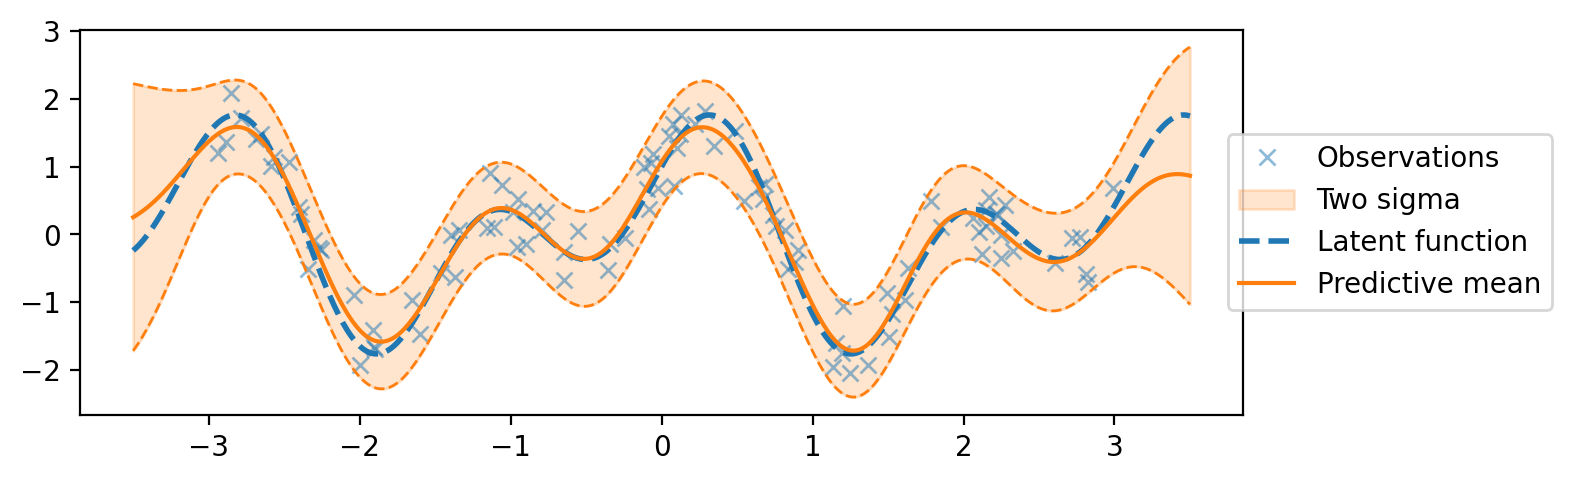

In [13]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_moments[0][0] - 2 * predictive_moments[0][1],
    predictive_moments[0][0] + 2 * predictive_moments[0][1],
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_moments[0][0] - 2 * predictive_moments[0][1],
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_moments[0][0] + 2 * predictive_moments[0][1],
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_moments[0][0], label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
plt.show()

# Try to set data

In [13]:
n = 200
noise = 0.35

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.5, maxval=3.5, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

newD = gpx.Dataset(X=x, y=y)

In [14]:
model.set_data(newD)

In [15]:
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
newxtest = jnp.linspace(-4.5, 4.5, 750).reshape(-1, 1)
newytest = f(newxtest)

In [17]:
latent_dist = model.models[0].predict(newxtest, train_data=D)
predictive_dist = model.models[0].likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

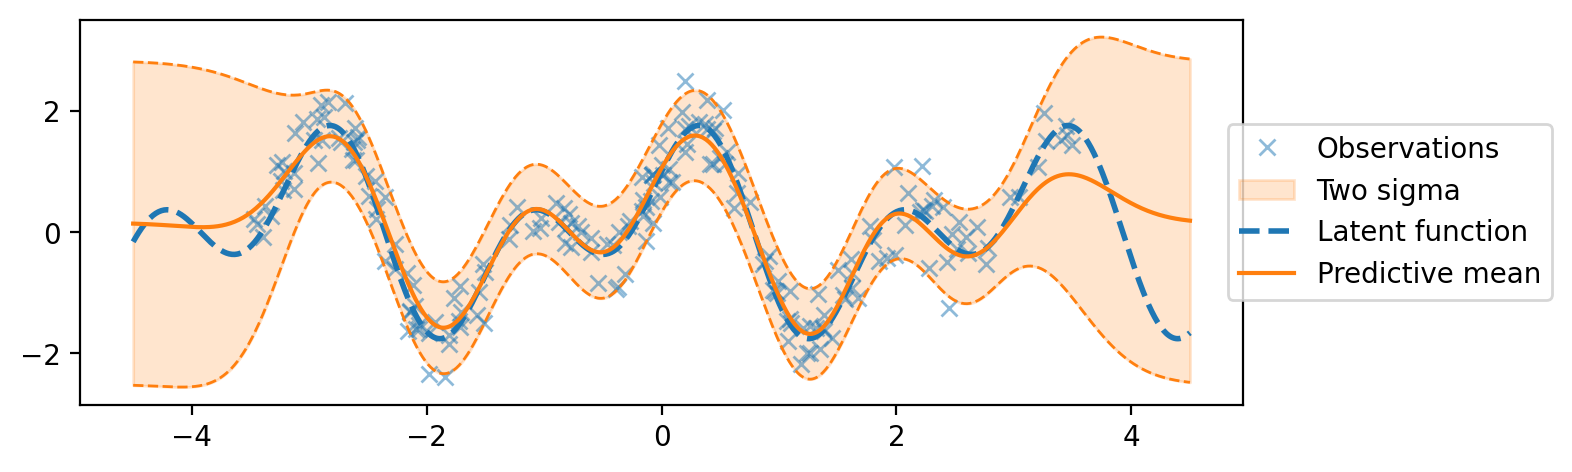

In [18]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    newxtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    newxtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    newxtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    newxtest, newytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(newxtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
plt.show()

# Now have two D inputs

In [19]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,2))
f = lambda x: jnp.sin(4 * x[:,0]) + jnp.cos(2 * x[:,1])
signal = f(x).reshape(-1,1)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

In [20]:
model = DynamicalModel(data=D,targets=True)

In [21]:
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
xtest = jnp.linspace(-3.5, 3.5, 1000).reshape(500, 2)
ytest = f(xtest).reshape(-1,1)
latent_dist = model.models[0].predict(xtest, train_data=D)
predictive_dist = model.models[0].likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

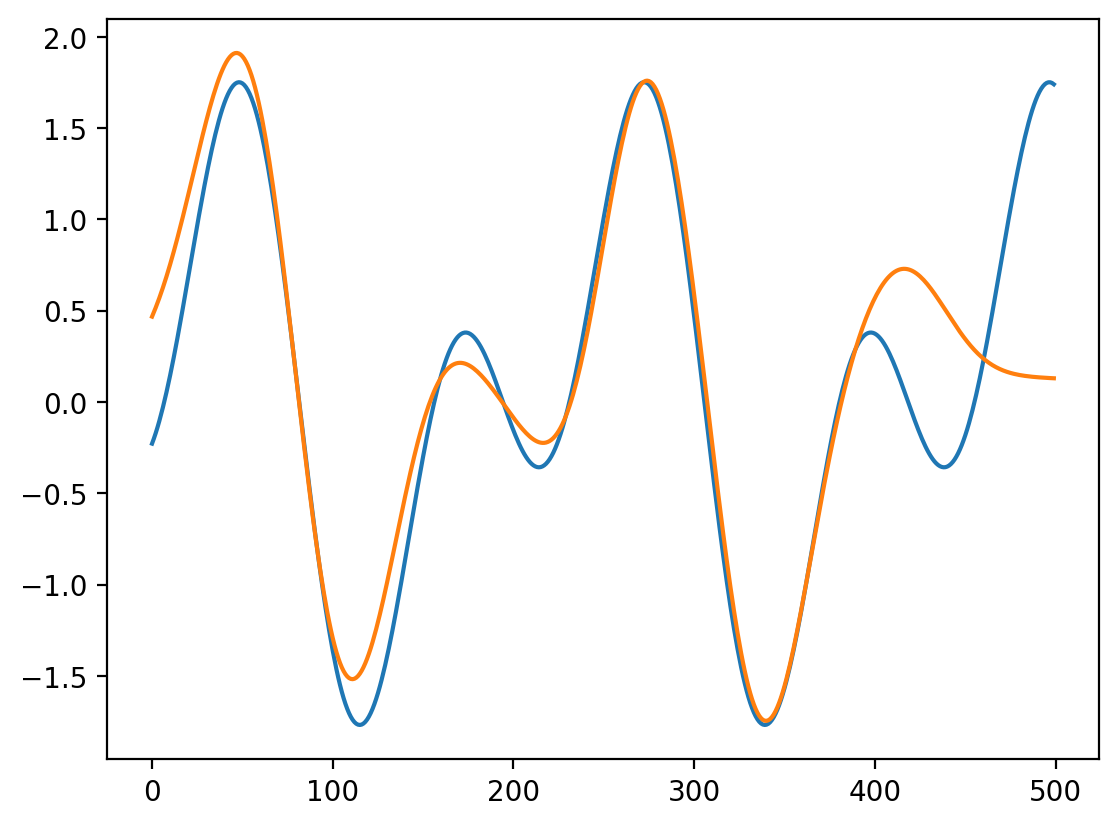

In [23]:
plt.plot(ytest)
plt.plot(predictive_mean)

Should use a different kernel! (and how should we plot this?)

# Try multiple outputs?

In [24]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,1))
f = lambda x: jnp.hstack(((jnp.sin(4 * x),jnp.cos(2 * x))))
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

In [25]:
model = DynamicalModel(data=D,targets=True)

In [26]:
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

In [28]:
predictive_mean = []
predictive_std = []
for i in range(len(model.models)):
    latent_dist = model.models[i].predict(xtest, train_data=gpx.Dataset(X=D.X, y=D.y[:,i].reshape(-1,1)))
    predictive_dist = model.models[0].likelihood(latent_dist)

    predictive_mean.append(predictive_dist.mean())
    predictive_std.append(predictive_dist.stddev())

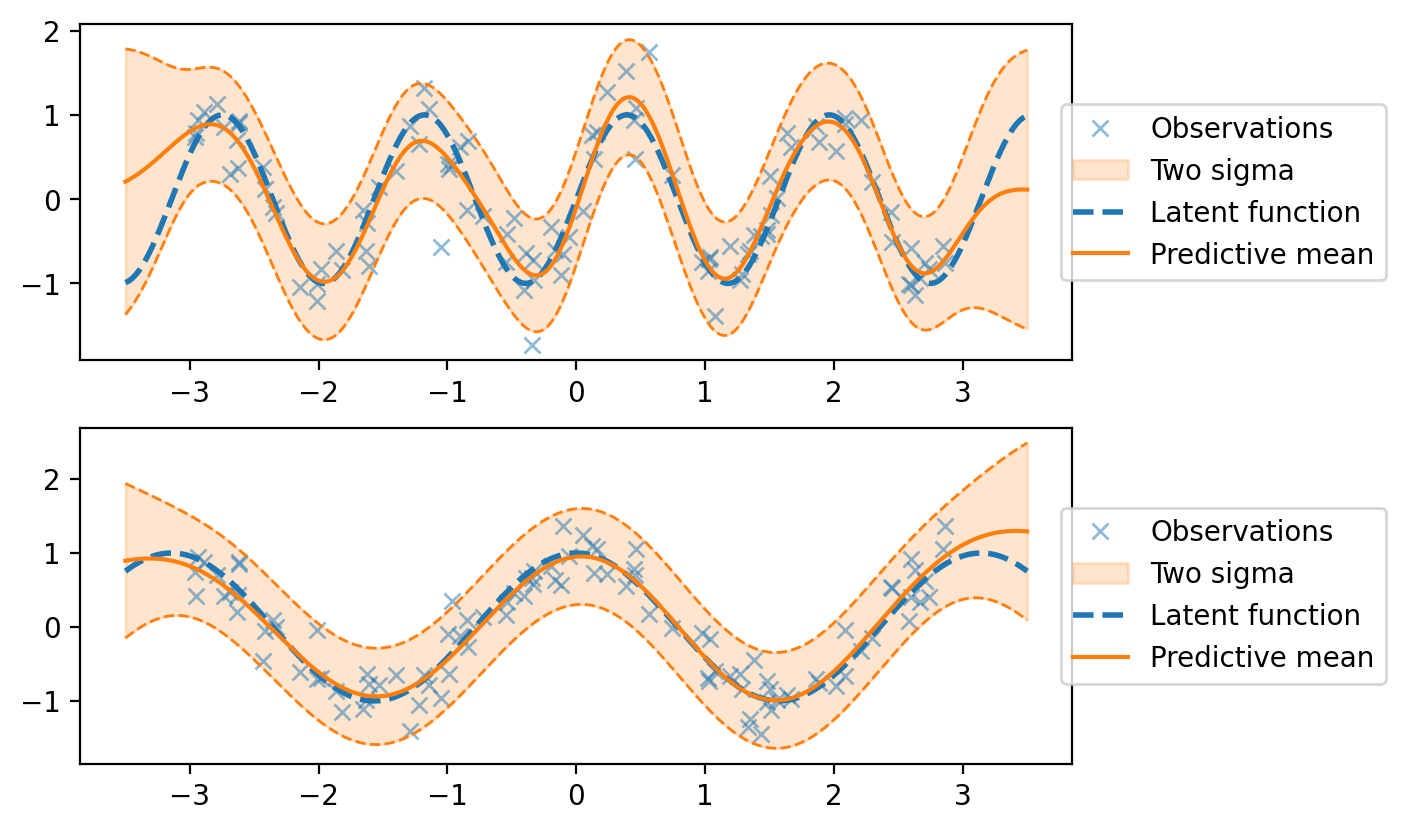

In [29]:
fig, ax = plt.subplots(2,1)
for i in range(2):
    ax[i].plot(x, y[:,i], "x", label="Observations", color=cols[0], alpha=0.5)
    ax[i].fill_between(
        xtest.squeeze(),
        predictive_mean[i] - 2 * predictive_std[i],
        predictive_mean[i] + 2 * predictive_std[i],
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax[i].plot(
        xtest,
        predictive_mean[i] - 2 * predictive_std[i],
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax[i].plot(
        xtest,
        predictive_mean[i] + 2 * predictive_std[i],
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax[i].plot(
        xtest, ytest[:,i], label="Latent function", color=cols[0], linestyle="--", linewidth=2
    )
    ax[i].plot(xtest, predictive_mean[i], label="Predictive mean", color=cols[1])
    ax[i].legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
plt.show()

## Compare against matlab?

In [31]:
d = 3  # Input dimension
k = 2  # Number of outputs
b = 100  # Number of basis functions

key, subkey = jr.split(key)
x0 = jr.uniform(key=subkey, shape=(b,d))
key, subkey = jr.split(key)
A = jr.uniform(key=subkey, shape=(d,k))

key, subkey = jr.split(key)
y0 = jnp.sin(x0).dot(A) + 1e-3 *(jr.uniform(key=subkey, shape=(b, k)) - 0.5)

In [32]:
D = gpx.Dataset(X=x0,y=y0)

In [123]:
model = DynamicalModel(data=D,targets=True)

In [108]:
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [72]:
# Generate input
key, subkey = jr.split(key)
input_mean = jr.uniform(key=subkey,shape=(1, d))  # But MATLAB defines it as m'
key, subkey = jr.split(key)
s = jr.uniform(key=subkey,shape=(d, d))
input_covariance = s.dot(s.T)  # Make s positive semidefinite

In [124]:
iK, beta = model.calculate_factorizations()

In [125]:
a,b,c = model.predict_given_factorizations(input_mean,input_covariance,iK,beta)

TypeError: dot_general requires contracting dimensions to have the same shape, got (3,) and (2,).

In [71]:
M, S, V = model.predict_on_noisy_inputs(m, s)

/Users/daniel.marthaler/.pyenv/versions/3.11.1/envs/pilco/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


ValueError: dimension mismatch (2, 100, 100) vs (100, 100)

In [68]:
model.noise

Array([1.00161423e-06, 1.00162926e-06], dtype=float64)

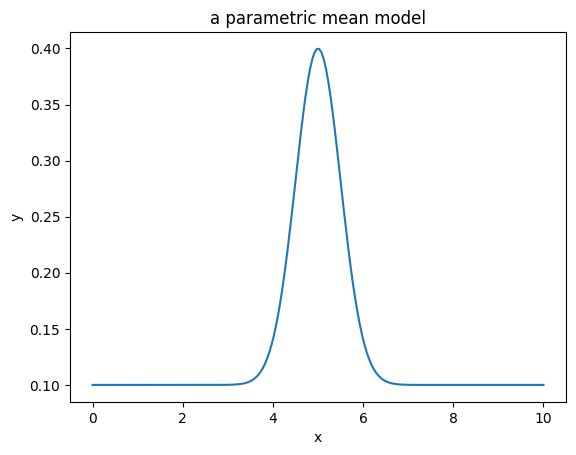

In [1]:
# from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)


def mean_function(params, X):
    mod = jnp.exp(-0.5 * jnp.square((X - params["loc"]) / jnp.exp(params["log_width"])))
    beta = jnp.array([1, mod])
    return params["amps"] @ beta


mean_params = {
    "amps": np.array([0.1, 0.3]),
    "loc": 5.0,
    "log_width": np.log(0.5),
}

X_grid = np.linspace(0, 10, 200)
model = jax.vmap(jax.tree_util.Partial(mean_function, mean_params))(X_grid)

plt.plot(X_grid, model)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("a parametric mean model")

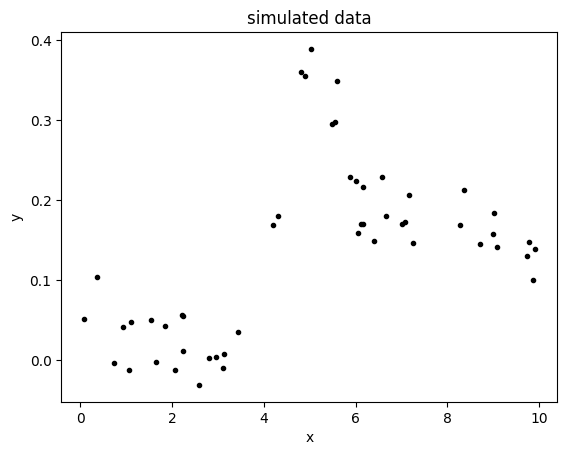

In [2]:
random = np.random.default_rng(135)
X = np.sort(random.uniform(0, 10, 50))
y = jax.vmap(jax.tree_util.Partial(mean_function, mean_params))(X)
y += 0.1 * np.sin(2 * np.pi * (X - 5) / 10.0)
y += 0.03 * random.normal(size=len(X))
plt.plot(X, y, ".k")
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("simulated data")

In [3]:
from tinygp import kernels, GaussianProcess


def build_gp(params):
    kernel = jnp.exp(params["log_gp_amp"]) * kernels.Matern52(
        jnp.exp(params["log_gp_scale"])
    )
    return GaussianProcess(
        kernel,
        X,
        diag=jnp.exp(params["log_gp_diag"]),
        mean=jax.tree_util.Partial(mean_function, params),
    )


@jax.jit
def loss(params):
    gp = build_gp(params)
    return -gp.log_probability(y)


params = dict(
    log_gp_amp=np.log(0.1),
    log_gp_scale=np.log(3.0),
    log_gp_diag=np.log(0.03),
    **mean_params,
)
loss(params)

Array(-33.08457135, dtype=float64)

In [4]:
import jaxopt

solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(jax.tree_util.tree_map(jnp.asarray, params))
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: -99.2646490029012


In [5]:
import optax as ox

In [6]:
optim = ox.adam(
    learning_rate=ox.linear_schedule(
        init_value=1e-1, end_value=1e-6, transition_steps=100
    )
)

In [7]:
import jax

In [8]:
def make_step(
    params,
    opt_state,
):
    loss_value, grads = jax.value_and_grad(loss)(params)
    updates, opt_state = optim.update(grads, opt_state, params)
    params = ox.apply_updates(params, updates)
    return params, opt_state, loss_value

In [9]:
params = dict(
    log_gp_amp=np.log(0.1),
    log_gp_scale=np.log(3.0),
    log_gp_diag=np.log(0.03),
    **mean_params,
)

In [10]:
patience = 3
patience_count = 0
opt_state = optim.init(params)
best_val = float("inf")
for _ in range(1000):
    params, opt_state, train_loss = make_step(params, opt_state)
    if train_loss < best_val:
        best_val = train_loss
        patience_count = 0
    else:
        patience_count += 1
    if patience_count > patience:
        break

In [11]:
best_val

Array(-99.2271286, dtype=float64)

In [12]:
type(jax.tree_util.Partial(mean_function, params))

jax.tree_util.Partial